# Introduction
This notebook is a compilation of relevant models, functions and components used in this framework.
It can be used for testing and visualization purposes and is supposed to help understanding how the different models interact in the greater context and what the influence of the components is.

The whole codebase is structured in a pyramid-like way where the model.invert() and model.forward() functions are at the top level. The level below that includes the albert_mobley module as part of the water module, which in turn calls functions from other modules such as absorption inside water. Depending on your application, you might want to go down the pyramid level by level to see where you can plug in your data or how you can combine different functions from different layers into a new model or application.

In this notebook, we start on the lowest level of the pyramid and then move upwards.

In [1]:
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from bio_optics.water import absorption, backscattering, attenuation, bottom_reflectance, fluorescence
from bio_optics.models import model
from bio_optics.helper import resampling, utils
from bio_optics.surface import air_water, surface
from bio_optics.atmosphere import absorption as atm_absorption, downwelling_irradiance, ET_solar_irradiance, sky_radiance, transmittance

# Preparation

In [5]:
# Define wavelength range and sampling rate
wavelengths=np.arange(400,850)

## Resampling

While many of the components in bio-optical modelling can be described by mathematical functions, some components are based on measurements or outputs from other models, e.g., the absorption coefficient of ozone has been generated with MODTRAN. These data need to be resampled to match the desired wavelength settings.

In [6]:
# Extraterrestrial solar irradiance
E0_res = resampling.resample_E0(wavelengths=wavelengths)

# Atmosphere 
a_oz_res = resampling.resample_a_oz(wavelengths=wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths=wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths=wavelengths)

# Water
a_w_res = resampling.resample_a_w(wavelengths=wavelengths)
da_w_div_dT_res = resampling.resample_da_w_div_dT(wavelengths=wavelengths)
a_i_spec_res = resampling.resample_a_i_spec(wavelengths)
bb_w_res = resampling.resample_bb_w(wavelengths=wavelengths)
b_phy_norm_res = resampling.resample_b_phy_norm(wavelengths=wavelengths)
A_res = resampling.resample_A(wavelengths=wavelengths)
n2_res = resampling.resample_n(wavelengths=wavelengths)

# Bottom
R_b_i_res = resampling.resample_R_b_i(wavelengths=wavelengths)

c:\Users\Marcel\.conda\envs\bio_optics2\lib\site-packages\spectral\algorithms\resampling.py:143: RuntimeWarning: invalid value encountered in true_divide
  contribs = contribs / A
spectral:INFO: No overlap for target band 322 (722.000000 / 1.000000)
spectral:INFO: No overlap for target band 323 (723.000000 / 1.000000)
spectral:INFO: No overlap for target band 324 (724.000000 / 1.000000)
spectral:INFO: No overlap for target band 325 (725.000000 / 1.000000)
spectral:INFO: No overlap for target band 326 (726.000000 / 1.000000)
spectral:INFO: No overlap for target band 327 (727.000000 / 1.000000)
spectral:INFO: No overlap for target band 328 (728.000000 / 1.000000)
spectral:INFO: No overlap for target band 329 (729.000000 / 1.000000)
spectral:INFO: No overlap for target band 330 (730.000000 / 1.000000)
spectral:INFO: No overlap for target band 331 (731.000000 / 1.000000)
spectral:INFO: No overlap for target band 332 (732.000000 / 1.000000)
spectral:INFO: No overlap for target band 333 (733

# Atmosphere

## Extraterrestrial solar irradiance

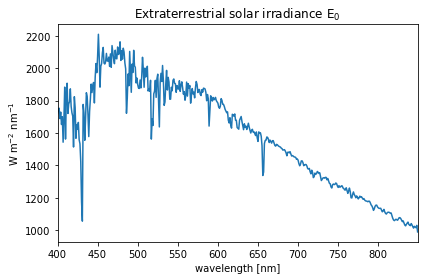

In [7]:
E0 = ET_solar_irradiance.E0(wavelengths, E0_res=E0_res)

plt.plot(wavelengths, E0)
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1}}$")
plt.title("Extraterrestrial solar irradiance $\mathrm{E_{0}}$")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.tight_layout()
plt.show()

## Absorption

### Ozone

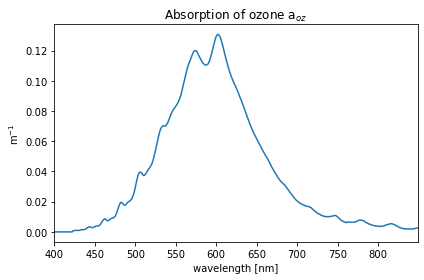

In [8]:
a_oz = atm_absorption.a_oz(wavelengths, a_oz_res=a_oz_res)

plt.plot(wavelengths, a_oz)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{m^{-1}}$")
plt.title("Absorption of ozone $\mathrm{a}_{oz}$")
plt.tight_layout()
plt.show()

### Water Vapor

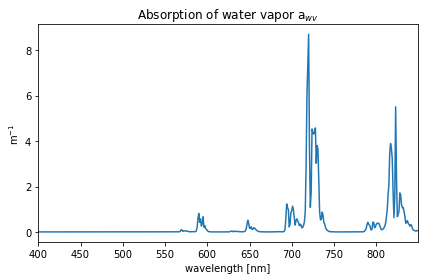

In [9]:
a_wv = atm_absorption.a_wv(wavelengths, a_wv_res=a_wv_res)

plt.plot(wavelengths, a_wv)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{m^{-1}}$")
plt.title("Absorption of water vapor $\mathrm{a}_{wv}$")
plt.tight_layout()
plt.show()

### Oxygen

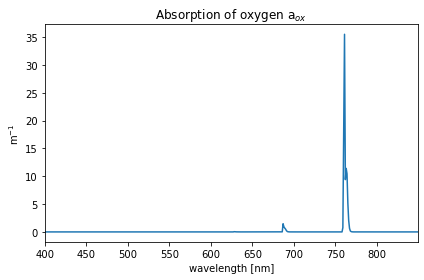

In [10]:
a_ox = atm_absorption.a_ox(wavelengths, a_ox_res=a_ox_res)

plt.plot(wavelengths, a_ox)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{m^{-1}}$")
plt.title("Absorption of oxygen $\mathrm{a}_{ox}$")
plt.tight_layout()
plt.show()

## Transmittance

In [12]:
P = 1013.25                     # atmospheric pressure [mbar]
theta_sun = np.radians(30)      # solar zenith angle [rad]
alpha = 1.317                   # Angstroem exponent 
beta = 0.2606                   # turbidity coefficient
WV = 2.5                        # precipitable water [cm]
H_oz = 0.38                     # ozone scale height [cm]
AM=1                            # air mass type [1..10]
RH=60                           # relative humidity [%]

### Rayleigh scattering

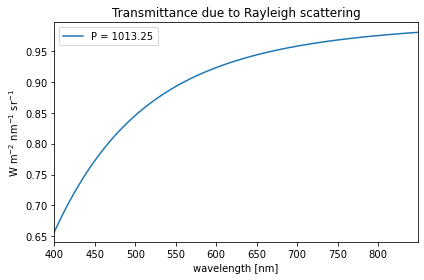

In [13]:
T_r = transmittance.T_r(wavelengths, theta_sun=theta_sun, P=P)

plt.plot(wavelengths, T_r, label='P = '+str(P))
plt.legend()
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Transmittance due to Rayleigh scattering")
plt.tight_layout()
plt.show()

### Aerosol absorption

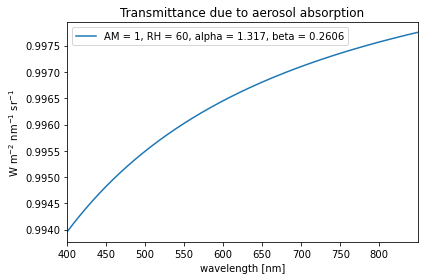

In [14]:
T_aa = transmittance.T_aa(wavelengths, theta_sun=theta_sun, AM=AM, RH=RH, alpha=alpha, beta=beta)

plt.plot(wavelengths, T_aa, label='AM = '+str(AM)+', RH = '+str(RH)+', alpha = '+str(alpha)+', beta = '+str(beta))
plt.legend()
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Transmittance due to aerosol absorption")
plt.tight_layout()
plt.show()

### Aerosol scattering

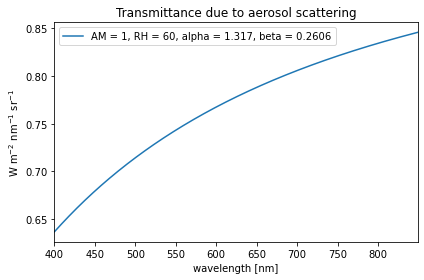

In [15]:
T_as = transmittance.T_as(wavelengths, theta_sun=theta_sun, AM=AM, RH=RH, alpha=alpha, beta=beta)

plt.plot(wavelengths, T_as, label='AM = '+str(AM)+', RH = '+str(RH)+', alpha = '+str(alpha)+', beta = '+str(beta))
plt.legend()
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Transmittance due to aerosol scattering")
plt.tight_layout()
plt.show()

### Ozone absorption

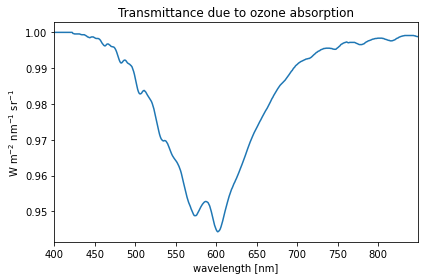

In [16]:
T_oz = transmittance.T_oz(wavelengths, theta_sun=theta_sun, H_oz=H_oz, a_oz_res=a_oz_res)

plt.plot(wavelengths, T_oz)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Transmittance due to ozone absorption")
plt.tight_layout()
plt.show()

### Oxygen absorption

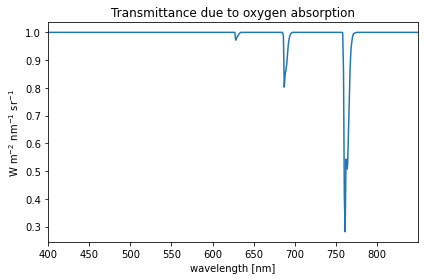

In [17]:
T_ox = transmittance.T_ox(wavelengths, theta_sun=theta_sun, P=P, a_ox_res=a_ox_res)

plt.plot(wavelengths, T_ox)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Transmittance due to oxygen absorption")
plt.tight_layout()
plt.show()

### Water vapor absorption

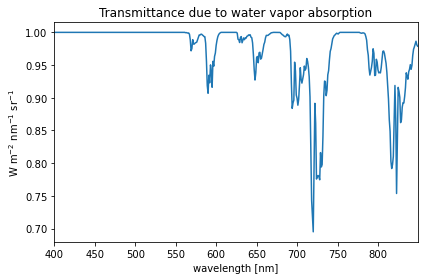

In [18]:
T_wv = transmittance.T_wv(wavelengths, theta_sun=theta_sun, WV=WV, a_wv_res=a_wv_res)

plt.plot(wavelengths, T_wv)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Transmittance due to water vapor absorption")
plt.tight_layout()
plt.show()

## Downwelling irradiance

### Direct component of the downwelling irradiance

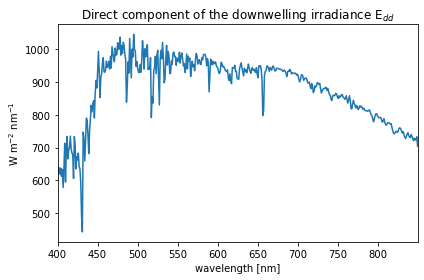

In [19]:
Ed_d = downwelling_irradiance.Ed_d(wavelengths, E0_res=E0_res, a_oz_res=a_oz_res, a_ox_res=a_oz_res, a_wv_res=a_oz_res)

plt.plot(wavelengths, Ed_d)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1}}$")
plt.title("Direct component of the downwelling irradiance $\mathrm{E}_{dd}$")
plt.tight_layout()
plt.show()

### Diffuse component of downwelling irradiance due to Rayleigh scattering

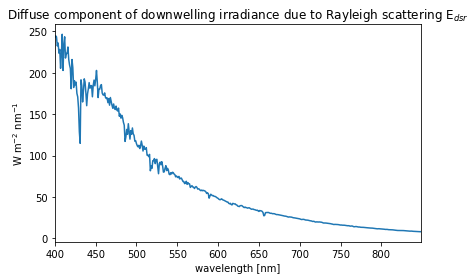

In [20]:
Ed_sr = downwelling_irradiance.Ed_sr(wavelengths, E0_res=E0_res, a_oz_res=a_oz_res, a_ox_res=a_oz_res, a_wv_res=a_oz_res)

plt.plot(wavelengths, Ed_sr)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1}}$")
plt.title("Diffuse component of downwelling irradiance due to Rayleigh scattering $\mathrm{E}_{dsr}$")
plt.tight_layout()
plt.show()

### Diffuse component of downwelling irradiance due to aerosol scattering

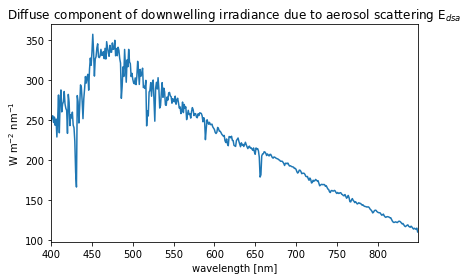

In [21]:
Ed_sa = downwelling_irradiance.Ed_sa(wavelengths, E0_res=E0_res, a_oz_res=a_oz_res, a_ox_res=a_oz_res, a_wv_res=a_oz_res)

plt.plot(wavelengths, Ed_sa)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1}}$")
plt.title("Diffuse component of downwelling irradiance due to aerosol scattering $\mathrm{E}_{dsa}$")
plt.tight_layout()
plt.show()

### Total downwelling irradiance

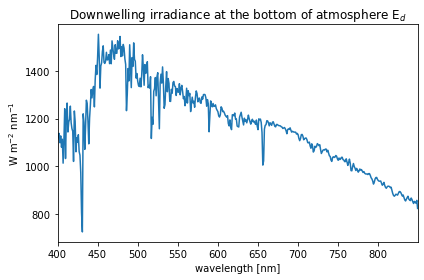

In [22]:
Ed_s = downwelling_irradiance.Ed_s(Ed_sr, Ed_sa)
Ed = Ed_d + Ed_s

plt.plot(wavelengths, Ed)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1}}$")
plt.title("Downwelling irradiance at the bottom of atmosphere $\mathrm{E}_{d}$")
plt.tight_layout()
plt.show()

## Sky radiance

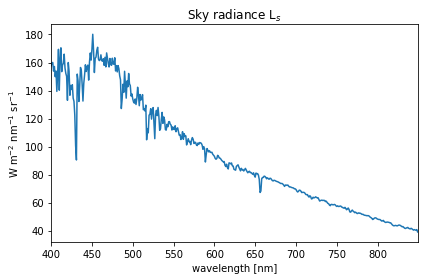

In [25]:
f_dd = 1
f_ds = 1
g_dd = 0.002
g_dsr = 1/np.pi
g_dsa = 1/np.pi

L_s = sky_radiance.L_s(f_dd=f_dd, 
                       f_ds=f_ds, 
                       g_dd=g_dd, 
                       Ed_d=Ed_d, 
                       g_dsr=g_dsr, 
                       Ed_sr=Ed_sr, 
                       g_dsa=g_dsa, 
                       Ed_sa=Ed_sa)

plt.plot(wavelengths, L_s)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Sky radiance $\mathrm{L}_{s}$")
plt.tight_layout()
plt.show()

# Surface

## Radiance of water surface

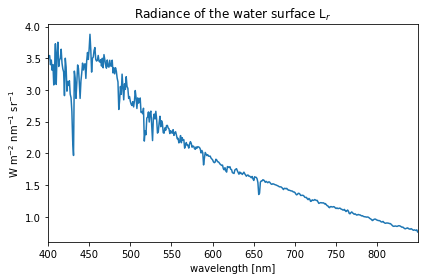

In [26]:
rho_L = air_water.fresnel(theta_inc=np.radians(1e-10), n2=n2_res)

plt.plot(wavelengths, surface.L_surf(L_s=L_s, rho_L=rho_L))
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Radiance of the water surface $\mathrm{L}_{r}$")
plt.tight_layout()
plt.show()

## Radiance reflectance of water surface (glint)

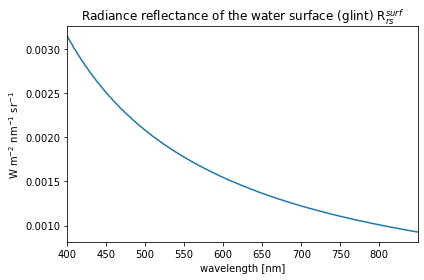

In [27]:
Rrs_surf = surface.Rrs_surf(Ed=Ed, L_s=L_s, rho_L=rho_L, d_r=0)

plt.plot(wavelengths, Rrs_surf)
plt.xlabel("wavelength [nm]")
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylabel("$\mathrm{W \ m^{-2} \ nm^{-1} \ sr^{-1}}$")
plt.title("Radiance reflectance of the water surface (glint) $\mathrm{R}_{rs}^{surf}$")
plt.tight_layout()
plt.show()

# Water

## Absorption

### Pure water

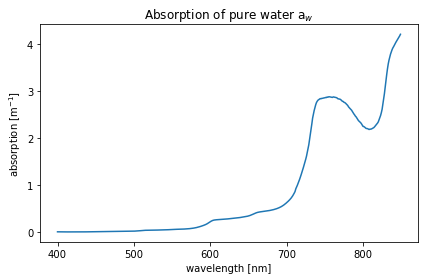

In [28]:
a_w = absorption.a_w(wavelengths=wavelengths, a_w_res=a_w_res)

plt.plot(wavelengths, a_w)
plt.xlabel("wavelength [nm]")
plt.ylabel("absorption [m$^{-1}$]")
plt.title("Absorption of pure water $\mathrm{a}_{w}$")
plt.tight_layout()
plt.show()

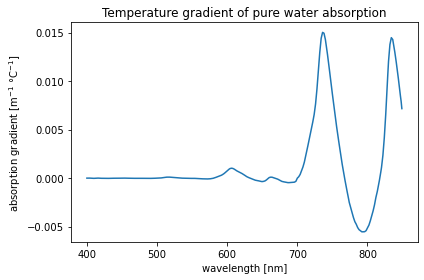

In [29]:
da_w_div_dT = absorption.da_w_div_dT(wavelengths=wavelengths, da_w_div_dT_res=da_w_div_dT_res)

plt.plot(wavelengths, da_w_div_dT)
plt.xlabel("wavelength [nm]")
plt.ylabel("absorption gradient [$\mathrm{m}^{-1}\ \u00b0 \mathrm{C}^{-1}$]")
plt.title("Temperature gradient of pure water absorption")
plt.tight_layout()
plt.show()

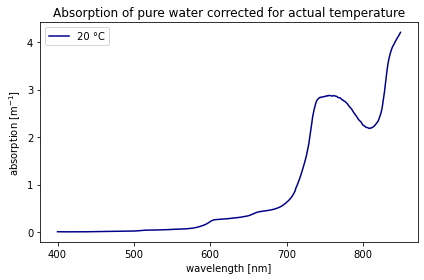

In [31]:
a_w_T = absorption.a_w_T(wavelengths=wavelengths, T_W=20, a_w_res=a_w_res, da_W_div_dT_res=da_w_div_dT_res)

plt.plot(wavelengths, a_w_T, label="20 \u00b0C", c="darkblue")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorption [m$^{-1}$]")
plt.title("Absorption of pure water corrected for actual temperature")
plt.legend()
plt.tight_layout()
plt.show()

### Phytoplankton

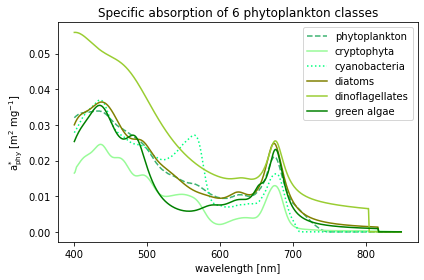

In [32]:
plt.plot(wavelengths, absorption.a_ph(C_0=1, wavelengths=wavelengths, a_i_spec_res=a_i_spec_res), label="phytoplankton", linestyle='--', color="mediumseagreen")
plt.plot(wavelengths, absorption.a_ph(C_1=1, wavelengths=wavelengths, a_i_spec_res=a_i_spec_res), label="cryptophyta", color = "palegreen")
plt.plot(wavelengths, absorption.a_ph(C_2=1, wavelengths=wavelengths, a_i_spec_res=a_i_spec_res), label="cyanobacteria", linestyle=':', color="springgreen")
plt.plot(wavelengths, absorption.a_ph(C_3=1, wavelengths=wavelengths, a_i_spec_res=a_i_spec_res), label="diatoms", color="olive")
plt.plot(wavelengths, absorption.a_ph(C_4=1, wavelengths=wavelengths, a_i_spec_res=a_i_spec_res), label="dinoflagellates", color="yellowgreen")
plt.plot(wavelengths, absorption.a_ph(C_5=1, wavelengths=wavelengths, a_i_spec_res=a_i_spec_res), label="green algae", color="green")
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{a_{phy}^{*}\ [m^{2}\ mg^{-1}]}$")
plt.title("Specific absorption of 6 phytoplankton classes")
plt.legend()
plt.tight_layout()
plt.show()

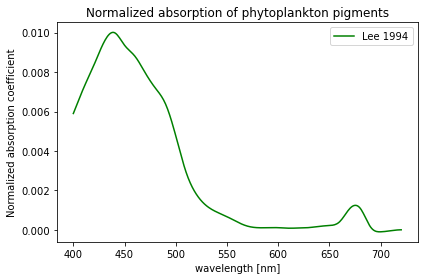

In [33]:
plt.plot(wavelengths, absorption.a_Phi(wavelengths=wavelengths, A_res=A_res), color="green", label="Lee 1994")
plt.xlabel("wavelength [nm]")
plt.ylabel("Normalized absorption coefficient")
plt.title("Normalized absorption of phytoplankton pigments")
plt.legend()
plt.tight_layout()
plt.show()

### CDOM

Different CDOM models exist in literature.

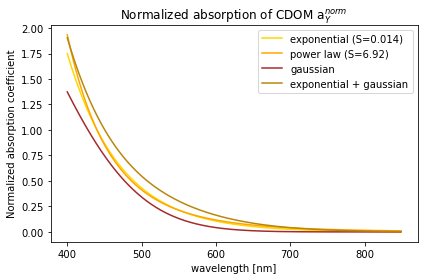

In [40]:
a_Y = absorption.a_Y(wavelengths=wavelengths, C_Y=1, lambda_0=440, S=0.014)
a_Y_pow = absorption.a_Y_pow(wavelengths=wavelengths, C_Y=1, lambda_0=440, S=6.92)
a_Y_gauss = absorption.a_Y_gauss(wavelengths=wavelengths, phi1=2, mu1=203, sigma1=60, phi2=3, mu2=250, sigma2=120)
a_Y_exp_gauss = absorption.a_Y_exp_gauss(C_Y=1, lambda_0=440, S=0.014, K=0, wavelengths=wavelengths, phi1=0.2, mu1=203, sigma1=200, phi2=0.05, mu2=500, sigma2=100)

plt.plot(wavelengths, a_Y, color="gold", label="exponential (S=0.014)")
plt.plot(wavelengths, a_Y_pow, color="orange", label="power law (S=6.92)")
plt.plot(wavelengths, a_Y_gauss, color="brown", label="gaussian")
plt.plot(wavelengths, a_Y_exp_gauss, color="darkgoldenrod", label="exponential + gaussian")
plt.xlabel("wavelength [nm]")
plt.ylabel("Normalized absorption coefficient")
plt.title("Normalized absorption of CDOM $\mathrm{a}_{Y}^{norm}$")
plt.tight_layout()
plt.legend()
plt.show()

### NAP

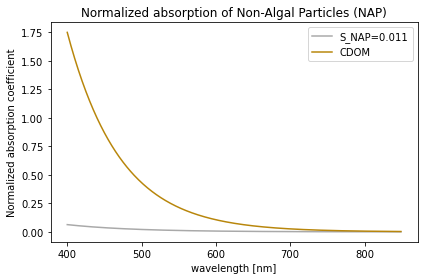

In [42]:
a_NAP = absorption.a_NAP(wavelengths=wavelengths, C_X=1, C_Mie=0, S_NAP=0.011)

plt.plot(wavelengths, a_NAP, color="darkgrey", label="S_NAP=0.011")
plt.plot(wavelengths, a_Y, color="darkgoldenrod", label="CDOM")
plt.xlabel("wavelength [nm]")
plt.ylabel("Normalized absorption coefficient")
plt.title("Normalized absorption of Non-Algal Particles (NAP)")
plt.legend()
plt.tight_layout()
plt.show()

### Particles

from SBOP (Li et al 2017)

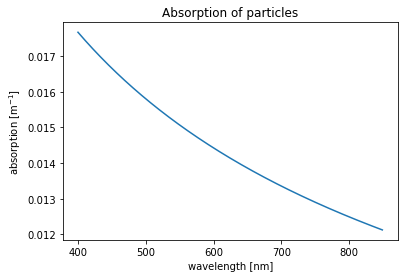

In [121]:
plt.plot(wavelengths, 0.75 * backscattering.bb_Mie(wavelengths=wavelengths, bb_Mie_spec=0.02, C_Mie=1, lambda_S=555, n=-0.5))
plt.xlabel("wavelength [nm]")
plt.ylabel("absorption [$\mathrm{m^{-1}}$]")
#plt.legend()
plt.title("Absorption of particles")
plt.show()

### Total

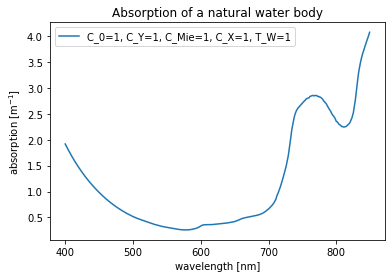

In [126]:
plt.plot(wavelengths, absorption.a(wavelengths=wavelengths, C_0=1, C_Y=1, C_Mie=1, C_X=1, T_W=1), label="C_0=1, C_Y=1, C_Mie=1, C_X=1, T_W=1")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorption [$\mathrm{m^{-1}}$]")
plt.legend()
plt.title("Absorption of a natural water body")
plt.show()

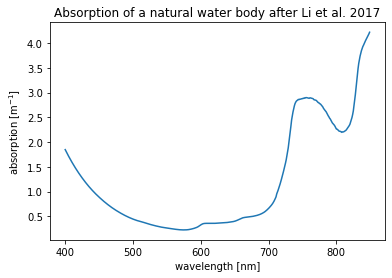

In [128]:
a_Li = absorption.a_w(wavelengths=wavelengths) + \
     absorption.a_Y(wavelengths=wavelengths, C_Y=1, S=0.015) + \
     0.75 * backscattering.bb_Mie(wavelengths=wavelengths, bb_Mie_spec=0.02, C_Mie=1, lambda_S=555, n=-0.5)

plt.plot(wavelengths, a_Li)
plt.xlabel("wavelength [nm]")
plt.ylabel("absorption [$\mathrm{m^{-1}}$]")
# plt.legend()
plt.title("Absorption of a natural water body after Li et al. 2017")
plt.show()

c:\Users\Marcel\.conda\envs\bio_optics2\lib\site-packages\spectral\algorithms\resampling.py:143: RuntimeWarning: invalid value encountered in true_divide
  contribs = contribs / A
spectral:INFO: No overlap for target band 322 (722.000000 / 1.000000)
spectral:INFO: No overlap for target band 323 (723.000000 / 1.000000)
spectral:INFO: No overlap for target band 324 (724.000000 / 1.000000)
spectral:INFO: No overlap for target band 325 (725.000000 / 1.000000)
spectral:INFO: No overlap for target band 326 (726.000000 / 1.000000)
spectral:INFO: No overlap for target band 327 (727.000000 / 1.000000)
spectral:INFO: No overlap for target band 328 (728.000000 / 1.000000)
spectral:INFO: No overlap for target band 329 (729.000000 / 1.000000)
spectral:INFO: No overlap for target band 330 (730.000000 / 1.000000)
spectral:INFO: No overlap for target band 331 (731.000000 / 1.000000)
spectral:INFO: No overlap for target band 332 (732.000000 / 1.000000)
spectral:INFO: No overlap for target band 333 (733

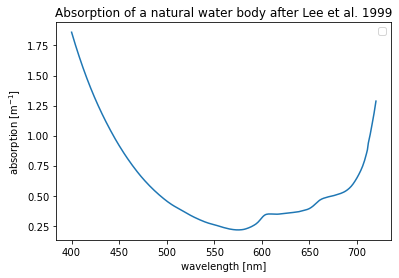

In [129]:
a_Lee = absorption.a_w(wavelengths=wavelengths) + \
        absorption.a_Y(wavelengths=wavelengths, C_Y=1, S=0.015) + \
        absorption.a_Phi(wavelengths=wavelengths, a_phy_440=0.05)

plt.plot(wavelengths, a_Lee)
plt.xlabel("wavelength [nm]")
plt.ylabel("absorption [$\mathrm{m^{-1}}$]")
plt.legend()
plt.title("Absorption of a natural water body after Lee et al. 1999")
plt.show()

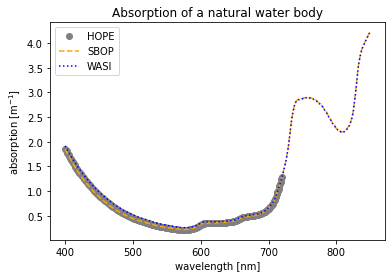

In [130]:
plt.plot(wavelengths, a_Lee, 'o', label="HOPE", c="gray")
plt.plot(wavelengths, a_Li, '--', label="SBOP", c="orange")
plt.plot(wavelengths, absorption.a(wavelengths=wavelengths, C_0=1, C_Y=1, C_Mie=1, C_X=1, T_W=20), ':', label="WASI", c="blue")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorption [$\mathrm{m^{-1}}$]")
plt.legend()
plt.title("Absorption of a natural water body")
plt.show()

## Backscattering

### Pure water

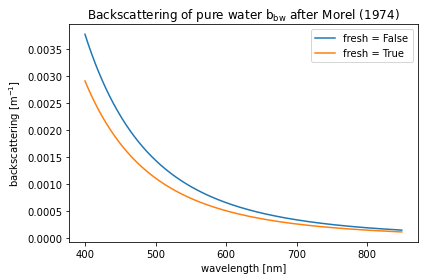

In [44]:
bb_w_fresh = backscattering.bb_w(wavelengths=wavelengths, fresh=False, bb_w_res=[])
bb_w_ocean= backscattering.bb_w(wavelengths=wavelengths, fresh=True, bb_w_res=[])

plt.plot(wavelengths, bb_w_fresh, label="fresh = False")
plt.plot(wavelengths, bb_w_ocean, label="fresh = True")
plt.xlabel("wavelength [nm]")
plt.ylabel("backscattering [$\mathrm{m}^{-1}$]")
plt.title("Backscattering of pure water $\mathrm{b_{bw}}$ after Morel (1974)")
plt.legend()
plt.tight_layout()
plt.show()

### Phytoplankton

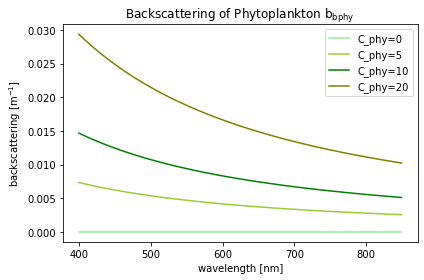

In [134]:
plt.plot(wavelengths, backscattering.bb_phy(wavelengths=wavelengths, C_phy=0, b_phy_norm_res=[]), label="C_phy=0", color="lightgreen")
plt.plot(wavelengths, backscattering.bb_phy(wavelengths=wavelengths, C_phy=5, b_phy_norm_res=[]), label="C_phy=5", color="yellowgreen")
plt.plot(wavelengths, backscattering.bb_phy(wavelengths=wavelengths, C_phy=10, b_phy_norm_res=[]), label="C_phy=10", color="green")
plt.plot(wavelengths, backscattering.bb_phy(wavelengths=wavelengths, C_phy=20, b_phy_norm_res=[]), label="C_phy=20", color="olive")
plt.xlabel("wavelength [nm]")
plt.ylabel("backscattering [m$^{-1}$]")
plt.title("Backscattering of Phytoplankton $\mathrm{b_{bphy}}$")
plt.legend()
plt.tight_layout()
plt.show()

### Particles Type 1

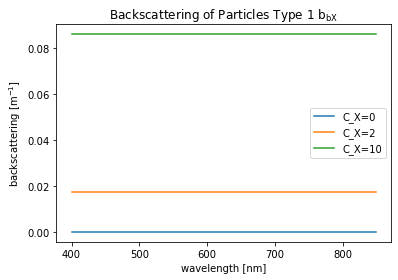

In [135]:
plt.plot(wavelengths, backscattering.bb_X(wavelengths=wavelengths, C_X=0), label="C_X=0")
plt.plot(wavelengths, backscattering.bb_X(wavelengths=wavelengths, C_X=2), label="C_X=2")
plt.plot(wavelengths, backscattering.bb_X(wavelengths=wavelengths, C_X=10), label="C_X=10")
plt.xlabel("wavelength [nm]")
plt.ylabel("backscattering [m$^{-1}$]")
plt.title("Backscattering of Particles Type 1 $\mathrm{b_{bX}}$")
plt.legend()
plt.show()

### Particle Type 2

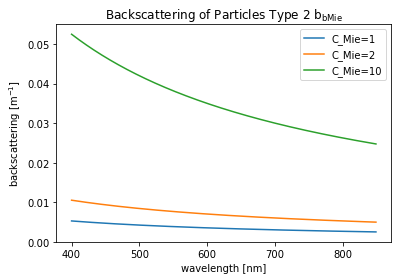

In [136]:
plt.plot(wavelengths, backscattering.bb_Mie(wavelengths=wavelengths, C_Mie=1), label="C_Mie=1")
plt.plot(wavelengths, backscattering.bb_Mie(wavelengths=wavelengths, C_Mie=2), label="C_Mie=2")
plt.plot(wavelengths, backscattering.bb_Mie(wavelengths=wavelengths, C_Mie=10), label="C_Mie=10")
plt.xlabel("wavelength [nm]")
plt.ylabel("backscattering [m$^{-1}$]")
plt.title("Backscattering of Particles Type 2 $\mathrm{b_{bMie}}$")
plt.legend()
plt.show()

### NAP

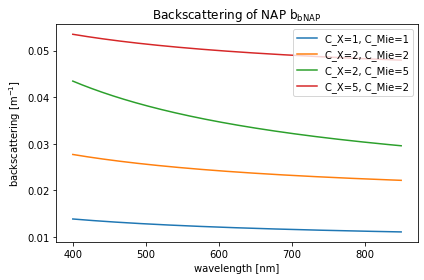

In [137]:
plt.plot(wavelengths, backscattering.bb_NAP(wavelengths=wavelengths, C_X=1, C_Mie=1), label="C_X=1, C_Mie=1")
plt.plot(wavelengths, backscattering.bb_NAP(wavelengths=wavelengths, C_X=2, C_Mie=2), label="C_X=2, C_Mie=2")
plt.plot(wavelengths, backscattering.bb_NAP(wavelengths=wavelengths, C_X=2, C_Mie=5), label="C_X=2, C_Mie=5")
plt.plot(wavelengths, backscattering.bb_NAP(wavelengths=wavelengths, C_X=5, C_Mie=2), label="C_X=5, C_Mie=2")
plt.xlabel("wavelength [nm]")
plt.ylabel("backscattering [m$^{-1}$]")
plt.title("Backscattering of NAP $\mathrm{b_{bNAP}}$")
plt.legend()
plt.tight_layout()
plt.show()

### Particles

from SBOP (Li et al 2017)

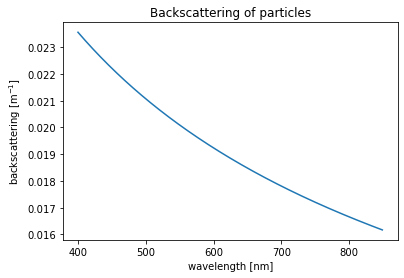

In [139]:
plt.plot(wavelengths, backscattering.bb_Mie(wavelengths=wavelengths, bb_Mie_spec=0.02, C_Mie=1, lambda_S=555, n=-0.5))
plt.xlabel("wavelength [nm]")
plt.ylabel("backscattering [$\mathrm{m^{-1}}$]")
#plt.legend()
plt.title("Backscattering of particles")
plt.show()

### Total

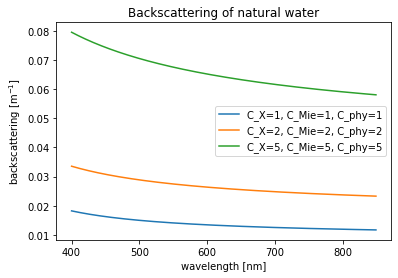

In [53]:
plt.plot(wavelengths, backscattering.bb(wavelengths=wavelengths, C_X=1, C_Mie=1, C_phy=1), label="C_X=1, C_Mie=1, C_phy=1")
plt.plot(wavelengths, backscattering.bb(wavelengths=wavelengths, C_X=2, C_Mie=2, C_phy=2), label="C_X=2, C_Mie=2, C_phy=2")
plt.plot(wavelengths, backscattering.bb(wavelengths=wavelengths, C_X=5, C_Mie=5, C_phy=5), label="C_X=5, C_Mie=5, C_phy=5")
plt.xlabel("wavelength [nm]")
plt.ylabel("backscattering [m$^{-1}$]")
plt.title("Backscattering of natural water")
plt.legend()
plt.show()

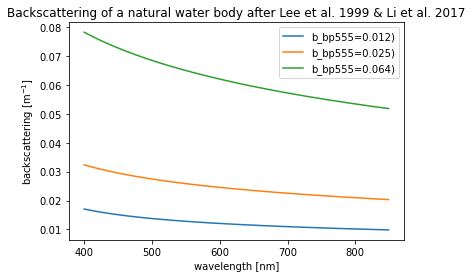

In [70]:
bs1 = backscattering.b_bw(wavelengths=wavelengths) + \
      backscattering.b_bMie(wavelengths=wavelengths, b_bMie_spec=0.012, C_Mie=1, lambda_S=555, n=-0.5)

bs2 = backscattering.b_bw(wavelengths=wavelengths) + \
      backscattering.b_bMie(wavelengths=wavelengths, b_bMie_spec=0.025, C_Mie=1, lambda_S=555, n=-0.5)

bs3 = backscattering.b_bw(wavelengths=wavelengths) + \
      backscattering.b_bMie(wavelengths=wavelengths, b_bMie_spec=0.064, C_Mie=1, lambda_S=555, n=-0.5)

plt.plot(wavelengths, bs1, label="b_bp555=0.012)")
plt.plot(wavelengths, bs2, label="b_bp555=0.025)")
plt.plot(wavelengths, bs3, label="b_bp555=0.064)")
plt.xlabel("wavelength [nm]")
plt.ylabel("backscattering [$\mathrm{m^{-1}}$]")
plt.legend()
plt.title("Backscattering of a natural water body after Lee et al. 1999 & Li et al. 2017")
plt.show()

## Fluorescence

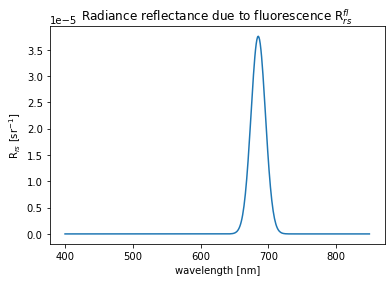

In [141]:
plt.plot(wavelengths, fluorescence.Rrs_fl(wavelengths=wavelengths))
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{R}_{rs}$ [$\mathrm{{sr}^{-1}}$]")
plt.title("Radiance reflectance due to fluorescence $\mathrm{R}_{rs}^{fl}$")
plt.show()

## Bottom

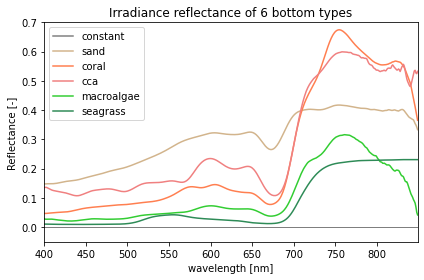

In [143]:
plt.plot(wavelengths, bottom_reflectance.Rrs_b(f_0=1, B_0=1, R_b_i_res=R_b_i_res), label="constant", color="gray")
plt.plot(wavelengths, bottom_reflectance.Rrs_b(f_1=1, B_1=1, R_b_i_res=R_b_i_res), label="sand", color="tan")
plt.plot(wavelengths, bottom_reflectance.Rrs_b(f_2=1, B_2=1, R_b_i_res=R_b_i_res), label="coral", color="coral")
plt.plot(wavelengths, bottom_reflectance.Rrs_b(f_3=1, B_3=1, R_b_i_res=R_b_i_res), label="cca", color="lightcoral")
plt.plot(wavelengths, bottom_reflectance.Rrs_b(f_4=1, B_4=1, R_b_i_res=R_b_i_res), label="macroalgae", color="limegreen")
plt.plot(wavelengths, bottom_reflectance.Rrs_b(f_5=1, B_5=1, R_b_i_res=R_b_i_res), label="seagrass", color="seagreen")
plt.hlines(0,350,1000, color='k',linewidth=0.5)
plt.xlabel("wavelength [nm]")
plt.ylabel("Reflectance [-]")
plt.title("Irradiance reflectance of 6 bottom types")
plt.legend()
plt.xlim(wavelengths.min(),wavelengths.max())
plt.ylim(-0.05, 0.7)
plt.tight_layout()
plt.show()

## Attenuation

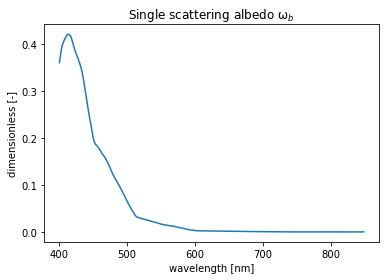

In [155]:
omega_b = attenuation.omega_b(absorption.a(wavelengths=wavelengths, C_0=0, C_Y=0, C_Mie=0, C_X=0),
                              backscattering.bb(wavelengths=wavelengths, C_X=0, C_Mie=0, C_phy=0, fresh=False))

plt.plot(wavelengths, omega_b)
plt.xlabel("wavelength [nm]")
plt.ylabel("dimensionless [-]")
plt.title("Single scattering albedo $\mathrm{\omega}_b$")
plt.show()

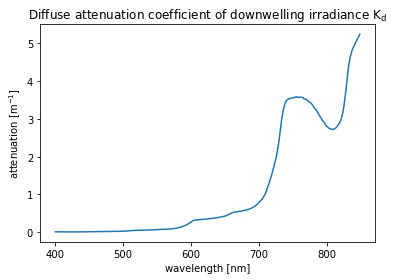

In [157]:
Kd = attenuation.Kd(absorption.a(wavelengths=wavelengths, C_0=0, C_Y=0, C_Mie=0, C_X=0), 
                    backscattering.bb(wavelengths=wavelengths, C_X=0, C_Mie=0, C_phy=0, fresh=False), 
                    cos_t_sun_p=np.cos(air_water.snell(np.radians(45), n2=n2_res)),
                    kappa_0 = 1.0546)

plt.plot(wavelengths, Kd)
plt.xlabel("wavelength [nm]")
plt.ylabel("attenuation [m$^{-1}$]")
plt.title("Diffuse attenuation coefficient of downwelling irradiance $\mathrm{K_{d}}$")
plt.show()

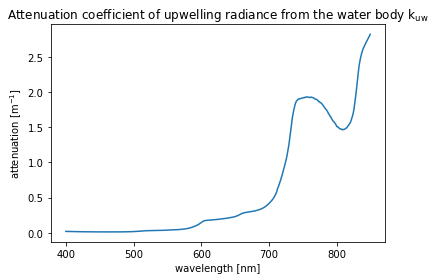

In [161]:
ku_w = attenuation.ku_w(absorption.a(wavelengths=wavelengths, C_0=0, C_Y=0, C_Mie=0, C_X=0), 
                        backscattering.bb(wavelengths=wavelengths, C_X=0, C_Mie=0, C_phy=0, fresh=False), 
                        omega_b,
                        cos_t_sun_p=np.cos(air_water.snell(np.radians(45), n2=n2_res)),
                        cos_t_view_p=np.cos(air_water.snell(np.radians(0), n2=n2_res)))

plt.plot(wavelengths, ku_w)
plt.xlabel("wavelength [nm]")
plt.ylabel("attenuation [m$^{-1}$]")
plt.title("Attenuation coefficient of upwelling radiance from the water body $\mathrm{k_{uw}}$")
plt.show()

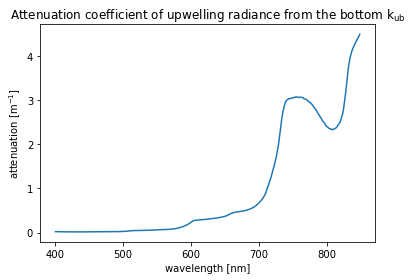

In [163]:
ku_b = attenuation.ku_b(absorption.a(wavelengths=wavelengths, C_0=0, C_Y=0, C_Mie=0, C_X=0), 
                        backscattering.bb(wavelengths=wavelengths, C_X=0, C_Mie=0, C_phy=0, fresh=False), 
                        omega_b,
                        cos_t_sun_p=np.cos(air_water.snell(np.radians(45), n2=n2_res)),
                        cos_t_view_p=np.cos(air_water.snell(np.radians(0), n2=n2_res)))

plt.plot(wavelengths, ku_b)
plt.xlabel("wavelength [nm]")
plt.ylabel("attenuation [m$^{-1}$]")
plt.title("Attenuation coefficient of upwelling radiance from the bottom $\mathrm{k_{ub}}$")
plt.show()

## Models

### Albert & Mobley (2003)

In [164]:
from bio_optics.water import albert_mobley

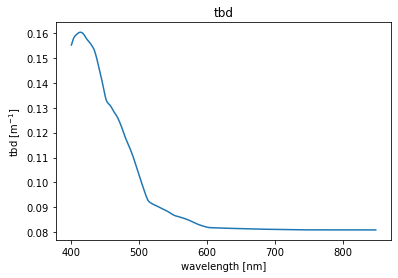

In [168]:
f_rs = albert_mobley.f_rs(omega_b=omega_b,
                          cos_t_sun_p = np.cos(np.radians(30)),
                          cos_t_view_p = np.cos(np.radians(0)))

plt.plot(wavelengths, f_rs)
plt.xlabel("wavelength [nm]")
plt.ylabel("tbd [m$^{-1}$]")
plt.title("tbd")
plt.show()

#### Deep water

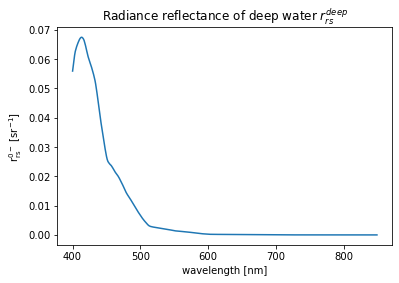

In [172]:
rrs_deep = albert_mobley.rrs_deep(f_rs, omega_b)

plt.plot(wavelengths, rrs_deep)
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{r}_{rs}^{0-}\ [sr^{-1}]}$")
plt.title("Radiance reflectance of deep water $r_{rs}^{deep}$")
plt.show()

#### Shallow water

Text(0.5, 1.0, 'Irradiance reflectance of the bottom $R_{rs}^{b}$')

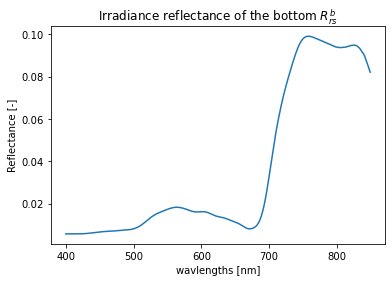

In [193]:
Rrs_b = bottom_reflectance.Rrs_b(wavelengths=wavelengths,
                                 f_0=0, 
                                 f_1=0,
                                 f_2=0.2,
                                 f_3=0,
                                 f_4=0,
                                 f_5=0.8)

plt.plot(wavelengths, Rrs_b)
plt.xlabel('wavlengths [nm]')
plt.ylabel('Reflectance [-]')
plt.title('Irradiance reflectance of the bottom $R_{rs}^{b}$')

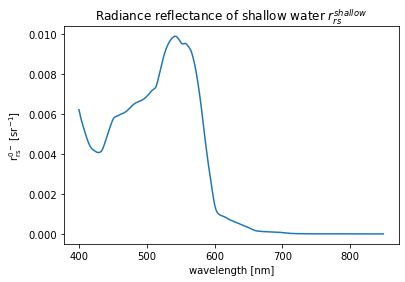

In [196]:
rrs_shallow = albert_mobley.rrs_shallow(rrs_deep=rrs_deep,
                                        Kd=Kd,
                                        ku_w=ku_w,
                                        zB=5,
                                        Rrs_b=Rrs_b,
                                        ku_b=ku_b,
                                        A_rs1=1.1576,
                                        A_rs2=1.0389)

plt.plot(wavelengths, rrs_shallow)
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{r}_{rs}^{0-}\ [sr^{-1}]}$")
plt.title("Radiance reflectance of shallow water $r_{rs}^{shallow}$")
plt.show()

### SBOP (Li et al. 2017)

#### Deep water

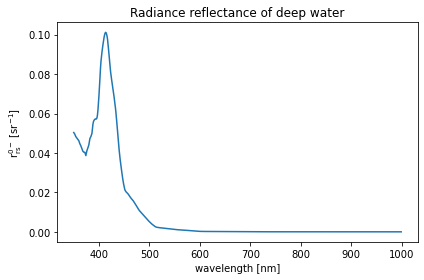

In [131]:
b_Li = backscattering.b_bw(wavelengths=wavelengths) + \
       backscattering.b_bMie(wavelengths=wavelengths, b_bMie_spec=0, C_Mie=1, lambda_S=555, n=-0.5)

a_Li = absorption.a_w(wavelengths=wavelengths) + \
       absorption.a_Y(wavelengths=wavelengths) + \
       0.75 * backscattering.b_bMie(wavelengths=wavelengths, b_bMie_spec=0, C_Mie=1, lambda_S=555, n=-0.5)

plt.plot(wavelengths, hope.r_rs_dp(u = b_Li / a_Li + b_Li))
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{r}_{rs}^{0-}\ [sr^{-1}]}$")
plt.title("Radiance reflectance of deep water")
#plt.legend()
plt.tight_layout()
plt.show()

#### Shallow water

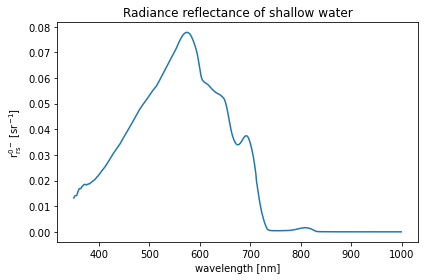

In [132]:
plt.plot(wavelengths, sbop.r_rs_sh(wavelengths=wavelengths,
                                   zB=2,
                                   C_Mie=0,
                                   C_Y=0.2,
                                   f_1=1,
                                   b_bMie_spec=1,
                                   q=0.75,
                                   n=-0.5))
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{r}_{rs}^{0-}\ [sr^{-1}]}$")
plt.title("Radiance reflectance of shallow water")
#plt.legend()
plt.tight_layout()
plt.show()

### HOPE (Lee et al. 1999)

#### Deep water

spectral:INFO: No overlap for target band 0 (350.000000 / 1.000000)
spectral:INFO: No overlap for target band 1 (351.000000 / 1.000000)
spectral:INFO: No overlap for target band 2 (352.000000 / 1.000000)
spectral:INFO: No overlap for target band 3 (353.000000 / 1.000000)
spectral:INFO: No overlap for target band 4 (354.000000 / 1.000000)
spectral:INFO: No overlap for target band 5 (355.000000 / 1.000000)
spectral:INFO: No overlap for target band 6 (356.000000 / 1.000000)
spectral:INFO: No overlap for target band 7 (357.000000 / 1.000000)
spectral:INFO: No overlap for target band 8 (358.000000 / 1.000000)
spectral:INFO: No overlap for target band 9 (359.000000 / 1.000000)
spectral:INFO: No overlap for target band 10 (360.000000 / 1.000000)
spectral:INFO: No overlap for target band 11 (361.000000 / 1.000000)
spectral:INFO: No overlap for target band 12 (362.000000 / 1.000000)
spectral:INFO: No overlap for target band 13 (363.000000 / 1.000000)
spectral:INFO: No overlap for target band 14

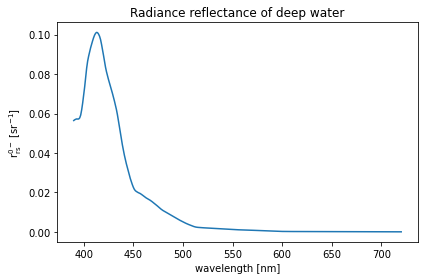

In [133]:
b_Lee = backscattering.b_bw(wavelengths=wavelengths) + \
        backscattering.b_bMie(wavelengths=wavelengths, b_bMie_spec=1, C_Mie=0, lambda_S=400, n=-0.5)

a_Lee = absorption.a_w(wavelengths=wavelengths) + \
     absorption.a_Y(wavelengths=wavelengths) + \
     absorption.a_Phi(wavelengths=wavelengths, a_phy_440=1e-10)

plt.plot(wavelengths, hope.r_rs_dp(u = b_Lee / a_Lee + b_Lee))
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{r}_{rs}^{0-}\ [sr^{-1}]}$")
plt.title("Radiance reflectance of deep water")
#plt.legend()
plt.tight_layout()
plt.show()

#### Shallow water

spectral:INFO: No overlap for target band 0 (350.000000 / 1.000000)
spectral:INFO: No overlap for target band 1 (351.000000 / 1.000000)
spectral:INFO: No overlap for target band 2 (352.000000 / 1.000000)
spectral:INFO: No overlap for target band 3 (353.000000 / 1.000000)
spectral:INFO: No overlap for target band 4 (354.000000 / 1.000000)
spectral:INFO: No overlap for target band 5 (355.000000 / 1.000000)
spectral:INFO: No overlap for target band 6 (356.000000 / 1.000000)
spectral:INFO: No overlap for target band 7 (357.000000 / 1.000000)
spectral:INFO: No overlap for target band 8 (358.000000 / 1.000000)
spectral:INFO: No overlap for target band 9 (359.000000 / 1.000000)
spectral:INFO: No overlap for target band 10 (360.000000 / 1.000000)
spectral:INFO: No overlap for target band 11 (361.000000 / 1.000000)
spectral:INFO: No overlap for target band 12 (362.000000 / 1.000000)
spectral:INFO: No overlap for target band 13 (363.000000 / 1.000000)
spectral:INFO: No overlap for target band 14

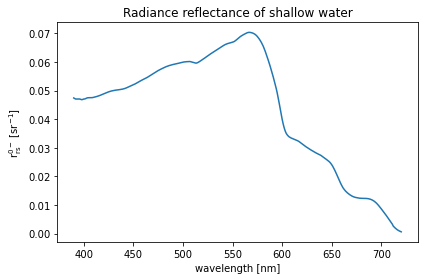

In [134]:
plt.plot(wavelengths, hope.r_rs_sh(wavelengths=wavelengths,
                                   zB=2,
                                   f_1=1,
                                   C_Mie=0,
                                   b_bMie_spec=1,
                                   a_phy_440=1e-10,
                                   theta_sun=np.radians(30)))
plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{r}_{rs}^{0-}\ [sr^{-1}]}$")
plt.title("Radiance reflectance of shallow water")
#plt.legend()
plt.tight_layout()
plt.show()

## Comparison

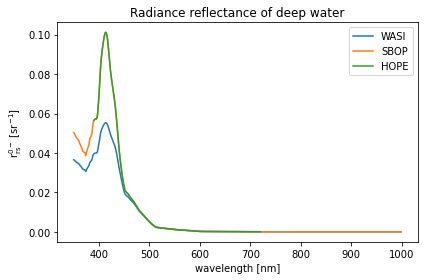

In [135]:
plt.plot(wavelengths, model.r_rs_dp(u = backscattering.b_b(wavelengths=wavelengths) / (absorption.a(wavelengths=wavelengths) + backscattering.b_b(wavelengths=wavelengths)),
                                   theta_sun = np.radians(30),
                                   theta_view = np.radians(0)),
        label="WASI")
plt.plot(wavelengths, hope.r_rs_dp(u = b_Li / a_Li + b_Li),
        label="SBOP")
plt.plot(wavelengths, hope.r_rs_dp(u = b_Lee / a_Lee + b_Lee),
        label="HOPE")

plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{r}_{rs}^{0-}\ [sr^{-1}]}$")
plt.title("Radiance reflectance of deep water")
plt.legend()
plt.tight_layout()
plt.show()

spectral:INFO: No overlap for target band 0 (350.000000 / 1.000000)
spectral:INFO: No overlap for target band 1 (351.000000 / 1.000000)
spectral:INFO: No overlap for target band 2 (352.000000 / 1.000000)
spectral:INFO: No overlap for target band 3 (353.000000 / 1.000000)
spectral:INFO: No overlap for target band 4 (354.000000 / 1.000000)
spectral:INFO: No overlap for target band 5 (355.000000 / 1.000000)
spectral:INFO: No overlap for target band 6 (356.000000 / 1.000000)
spectral:INFO: No overlap for target band 7 (357.000000 / 1.000000)
spectral:INFO: No overlap for target band 8 (358.000000 / 1.000000)
spectral:INFO: No overlap for target band 9 (359.000000 / 1.000000)
spectral:INFO: No overlap for target band 10 (360.000000 / 1.000000)
spectral:INFO: No overlap for target band 11 (361.000000 / 1.000000)
spectral:INFO: No overlap for target band 12 (362.000000 / 1.000000)
spectral:INFO: No overlap for target band 13 (363.000000 / 1.000000)
spectral:INFO: No overlap for target band 14

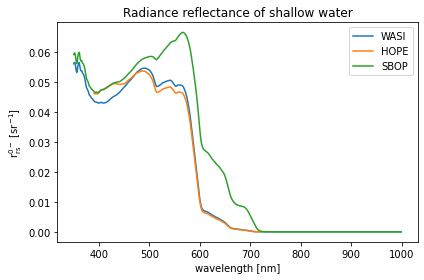

In [136]:
plt.plot(wavelengths, model.r_rs_sh(wavelengths=wavelengths, 
                                     f_1=1,
                                     B_1=1/np.pi,
                                     zB=5,
                                     theta_sun = np.radians(30),
                                     theta_view = np.radians(0),
                                     fresh=False)
        , label="WASI")

plt.plot(wavelengths, hope.r_rs_sh(wavelengths=wavelengths,
                                   C_Y=0,
                                   C_Mie=0,
                                   b_bMie_spec=1,
                                   lambda_S=400,
                                   n=-0.5,
                                   a_phy_440=1e-10,
                                   zB=5,
                                   f_1=1,
                                   B_1=1/np.pi,
                                   theta_sun=np.radians(30),
                                   g_0 = 0.089,
                                   g_1 = 0.125)
        , label="HOPE")

plt.plot(wavelengths, sbop.r_rs_sh(wavelengths=wavelengths,
                                   C_Y=0,
                                   C_Mie=0,
                                   b_bMie_spec=1,
                                   lambda_S=555,
                                   n=-0.5,
                                   zB=5,
                                   f_1=1,
                                   B_1=1/np.pi,
                                   g_0 = 0.084,
                                   g_1 = 0.17)
        , label="SBOP")

plt.xlabel("wavelength [nm]")
plt.ylabel("$\mathrm{{r}_{rs}^{0-}\ [sr^{-1}]}$")
plt.title("Radiance reflectance of shallow water")
plt.legend()
plt.tight_layout()
plt.show()

# TESTING

In [47]:
R_rs = pd.read_csv(r'C:\Users\mkoenig3\Dropbox (ASU)\GDCS_Asnerlab\1. Projects\CarbonMapper\04_Development\WQ\2023-01_Hawaii WQ\Field_data\SVC\G12_r_rs.csv', index_col=0)

i = 450

In [48]:
wavelengths = R_rs.columns[3:].astype(float).values

In [49]:
a_i_spec_res = resampling.resample_a_i_spec(wavelengths)
a_w_res = resampling.resample_a_w(wavelengths)
b_phy_norm_res = resampling.resample_b_phy_norm(wavelengths)
b_bw_res = resampling.resample_b_bw(wavelengths, fresh=False)
R_i_b_res = resampling.resample_R_i_b(wavelengths)
E_0_res = resampling.resample_E_0(wavelengths)
a_oz_res = resampling.resample_a_oz(wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths)
da_W_div_dT_res = resampling.resample_da_W_div_dT(wavelengths)

In [50]:
weights = np.ones(len(wavelengths))
# weights[wavelengths<500] = 2
# weights[wavelengths>800] = 5
# weights[(wavelengths>=600) & (wavelengths<=700)] = 2
# weights[(wavelengths>=675) & (wavelengths<=750)] = 0.1
# weights[(wavelengths>=760) & (wavelengths<=770)] = 0.1

## WASI

In [60]:
params = lmfit.Parameters()
params.add('C_0', value=0, min=0, max=100, vary=True)
params.add('C_1', value=0, min=0, max=1000, vary=False)
params.add('C_2', value=0, min=0, max=1000, vary=False)
params.add('C_3', value=0, min=0, max=1000, vary=False)
params.add('C_4', value=0, min=0, max=1000, vary=False)
params.add('C_5', value=0, min=0, max=1000, vary=False)
params.add('C_Y', value=0, min=0, max=5, vary=True)
params.add('C_X', value=0, min=0, max=100, vary=True)
params.add('C_Mie', value=0, min=0, max=100, vary=True)
params.add('f_0', value=0, min=0, max=10, vary=True)
params.add('f_1', value=1, min=0, max=10, vary=False)
params.add('f_2', value=0, min=0, max=10, vary=False)
params.add('f_3', value=0, min=0, max=10, vary=False)
params.add('f_4', value=0, min=0, max=10, vary=False)
params.add('f_5', value=0, min=0, max=10, vary=False)
params.add('B_0', value=1/np.pi, vary=False)
params.add('B_1', value=1/np.pi, vary=False)
params.add('B_2', value=1/np.pi, vary=False)
params.add('B_3', value=1/np.pi, vary=False)
params.add('B_4', value=1/np.pi, vary=False)
params.add('B_5', value=1/np.pi, vary=False)
params.add('b_bphy_spec', value=0.0010, vary=False)
params.add('b_bMie_spec', value=0.0042, vary=False)
params.add('b_bX_spec', value=0.0086, min=0, max=1, vary=False)
params.add('b_bX_norm_factor', value=1, vary=False)
params.add('a_NAP_spec_lambda_0', value=0.041, vary=False)
params.add('A', value=0.0006, vary=False)
params.add('B', value=-0.37, vary=False)
params.add('K', value=0, vary=False)
params.add('S', value=0.014, min=0.007, max=0.026, vary=False)
params.add('S_NAP', value=0.011, vary=False)
params.add('n', value=-1, vary=False)
params.add('lambda_0', value=440, vary=False)
params.add('lambda_S', value=500, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('theta_view', value=np.radians(0), min=np.radians(0), max=np.radians(90), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('case_1', value=False, vary=False)
params.add('fresh', value=False, vary=False)
params.add('T_W', value=20, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('zB', value=10, min=0, max=100, vary=True)
params.add('offset', value=0, min=-0.1, max=0.1, vary=False)
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, min=0.2, max=2, vary=False) 
params.add('beta', value=0.2606, min=0.16, max=0.5, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
params.add('rho_L', value=0.02006, vary=False) 
params.add('error_method', value=2, vary=False)
params.add('fit_surface', value=False, vary=False)

In [61]:
start = timeit.default_timer()

inv = model.invert(params, 
                      R_rs=R_rs.iloc[i, 3:].values.astype(float), 
                      wavelengths=wavelengths, 
                      weights=weights,
                      a_i_spec_res=a_i_spec_res,
                      a_w_res=a_w_res,
                      b_phy_norm_res=b_phy_norm_res,
                      b_bw_res=b_bw_res,
                      R_i_b_res=R_i_b_res,
                      E_0_res = E_0_res,
                      a_oz_res = a_oz_res,
                      a_ox_res = a_ox_res,
                      a_wv_res = a_wv_res,
                      da_W_div_dT_res = da_W_div_dT_res,
                      method="least_squares", 
                      max_nfev=400)

stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  0.07574029999886989


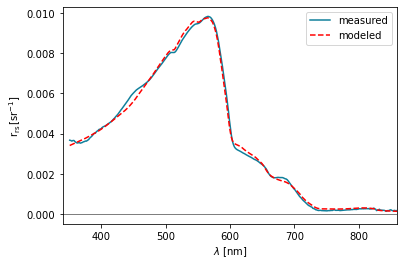

In [62]:
plt.plot(wavelengths, R_rs.iloc[i,3:].values, c='#0f7f9b', label="measured")
plt.plot(wavelengths, model.forward(inv.params, wavelengths), '--', c='red', label='modeled')
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
plt.xlim(340,860)
plt.legend()
plt.show()

## SBOP

In [144]:
n = -utils.estimate_y(R_rs.iloc[i, 3:].values.astype(float), wavelengths)

In [145]:
params = lmfit.Parameters()
params.add('C_Y', value=0.3, min=0, max=5, vary=True)
params.add('C_Mie', value=0.3, min=0, max=5, vary=True)
params.add('zB', value=10, min=0, max=100, vary=True)
params.add('f_0', value=0, min=0, max=10, vary=True)
params.add('f_1', value=1, min=0, max=10, vary=True)
params.add('f_2', value=0, min=0, max=10, vary=True)
params.add('f_3', value=0, min=0, max=10, vary=True)
params.add('f_4', value=0, min=0, max=10, vary=True)
params.add('f_5', value=0, min=0, max=10, vary=True)
params.add('B_0', value=1/np.pi, vary=False)
params.add('B_1', value=1/np.pi, vary=False)
params.add('B_2', value=1/np.pi, vary=False)
params.add('B_3', value=1/np.pi, vary=False)
params.add('B_4', value=1/np.pi, vary=False)
params.add('B_5', value=1/np.pi, vary=False)
params.add('S', value=0.015, vary=False)
params.add('lambda_0', value=440, vary=False)
params.add('lambda_S', value=555, vary=False)
# ESTIMATE N
params.add('n', value=n, vary=False)
############
params.add('b_bMie_spec', value=1, vary=False)
params.add('q', value=0.75, vary=False)
params.add('fresh', value=False, vary=False)
params.add('g_0', value=0.089, vary=False)
params.add('g_1', value=0.125, vary=False)
params.add('offset', value=0, min=-0.01, max=0.01, vary=True)
params.add('error_method', value=2, vary=False)

In [146]:
import timeit
start = timeit.default_timer()

inv = sbop.invert(params, 
                  R_rs=R_rs.iloc[i, 3:].values.astype(float), 
                  wavelengths=wavelengths, 
                  a_w_res = a_w_res,
                  b_bw_res = b_bw_res,
                  R_i_b_res = R_i_b_res,
                  method="least_squares", max_nfev=400)

stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  0.11716519999936281


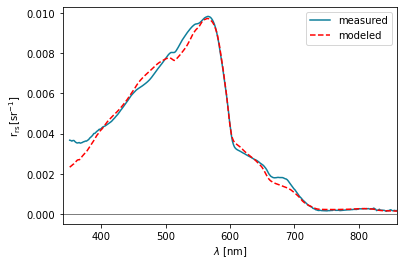

In [147]:
plt.plot(wavelengths, R_rs.iloc[i,3:], c='#0f7f9b', label="measured")
plt.plot(wavelengths, sbop.forward(inv.params, wavelengths), '--', c='red', label='modeled')
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
plt.xlim(340,860)
# plt.ticklabel_format(style='scientific')
plt.legend()
plt.show()

In [148]:
inv.params

name,value,standard error,relative error,initial value,min,max,vary
C_Y,0.12348852,0.00889474,(7.20%),0.3,0.00000000,5.00000000,True
C_Mie,0.01354167,0.00159321,(11.77%),0.3,0.00000000,5.00000000,True
zB,7.16780075,0.41881087,(5.84%),10,0.00000000,100.000000,True
f_0,7.6604e-22,0.09918607,(12947887750890871848960.00%),0,0.00000000,10.0000000,True
f_1,1.1442e-17,0.09184000,(802672225416164480.00%),1,0.00000000,10.0000000,True
f_2,6.2404e-30,0.11202732,(1795199541633834163019576246272.00%),0,0.00000000,10.0000000,True
f_3,1.0212e-34,0.07863367,(76998217362104827124464080557965312.00%),0,0.00000000,10.0000000,True
f_4,0.83495166,0.30727917,(36.80%),0,0.00000000,10.0000000,True
f_5,1.11008724,0.24955811,(22.48%),0,0.00000000,10.0000000,True
B_0,0.31830989,0.00000000,(0.00%),0.3183098861837907,-inf,inf,False


## HOPE

In [149]:
n = -utils.estimate_y(R_rs.iloc[i, 3:].values.astype(float), wavelengths, lambda1=440, lambda2=490, a=3.44, b=1, c=3.17, d=-2.01)

In [150]:
wl_mask = np.where(((wavelengths<720) & (wavelengths>400)),True,False)

In [151]:
A_res = resampling.resample_A(wavelengths[wl_mask])
a_w_res = resampling.resample_a_w(wavelengths[wl_mask])
b_bw_res = resampling.resample_b_bw(wavelengths[wl_mask])
R_i_b_res = resampling.resample_R_i_b(wavelengths[wl_mask])

In [152]:
params = lmfit.Parameters()
params.add('C_Y', value=0.3, min=0, max=5, vary=True)
params.add('C_Mie', value=0.3, min=0, max=5, vary=True)
params.add('a_phy_440', value=0.1, min=0, max=2, vary=True)
params.add('zB', value=10, min=0, max=100, vary=True)
params.add('f_0', value=0, min=0, max=10, vary=True)
params.add('f_1', value=1, min=0, max=10, vary=True)
params.add('f_2', value=0, min=0, max=10, vary=True)
params.add('f_3', value=0, min=0, max=10, vary=True)
params.add('f_4', value=0, min=0, max=10, vary=True)
params.add('f_5', value=0, min=0, max=10, vary=True)
params.add('B_0', value=1/np.pi, vary=False)
params.add('B_1', value=1/np.pi, vary=False)
params.add('B_2', value=1/np.pi, vary=False)
params.add('B_3', value=1/np.pi, vary=False)
params.add('B_4', value=1/np.pi, vary=False)
params.add('B_5', value=1/np.pi, vary=False)
params.add('S', value=0.015, vary=False)
params.add('lambda_0', value=440, vary=False)
params.add('lambda_S', value=400, vary=False)
params.add('n', value=n, vary=False)
params.add('b_bMie_spec', value=1, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('fresh', value=False, vary=False)
params.add('g_0', value=0.089, vary=False)
params.add('g_1', value=0.125, vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('offset', value=0, min=-0.01, max=0.01, vary=True)
params.add('error_method', value=2, vary=False)

In [153]:
import timeit
start = timeit.default_timer()

inv = hope.invert(params, 
                  R_rs=R_rs.iloc[i, 3:].values.astype(float)[wl_mask], 
                  wavelengths=wavelengths[wl_mask], 
                  a_w_res = a_w_res,
                  A_res = A_res,
                  b_bw_res = b_bw_res,
                  R_i_b_res = R_i_b_res,
                  method="least_squares", 
                  max_nfev=400)

stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  0.10694519999924523


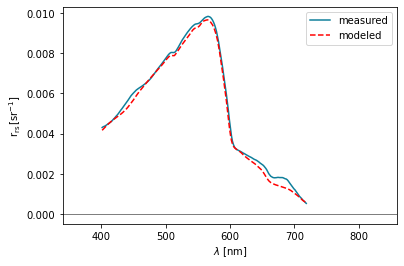

In [154]:
plt.plot(wavelengths[wl_mask], R_rs.iloc[i,3:][wl_mask], c='#0f7f9b', label="measured")
plt.plot(wavelengths[wl_mask], hope.forward(inv.params, wavelengths[wl_mask]), '--', c='red', label='modeled')
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
plt.xlim(340,860)
plt.legend()
plt.show()

In [155]:
inv.params

name,value,standard error,relative error,initial value,min,max,vary
C_Y,0.14785368,0.01295507,(8.76%),0.3,0.00000000,5.00000000,True
C_Mie,0.02095022,0.00305776,(14.60%),0.3,0.00000000,5.00000000,True
a_phy_440,0.04197127,0.01555758,(37.07%),0.1,0.00000000,2.00000000,True
zB,4.25273854,0.27907170,(6.56%),10,0.00000000,100.000000,True
f_0,1.0618e-10,0.42448873,(399773874315.67%),0,0.00000000,10.0000000,True
f_1,1.6570e-09,0.21220887,(12806445166.57%),1,0.00000000,10.0000000,True
f_2,2.7998e-09,0.07821508,(2793565252.63%),0,0.00000000,10.0000000,True
f_3,2.6505e-10,0.07709962,(29088487008.38%),0,0.00000000,10.0000000,True
f_4,0.96135562,0.33136881,(34.47%),0,0.00000000,10.0000000,True
f_5,0.75533386,0.27781646,(36.78%),0,0.00000000,10.0000000,True
